Molecule generation is a very active research field nowadays in cheminformatics. Deep generative models can be categorized into two major classess based on the representation of molecules: Graph-based and test-based (e.g., SMILES). 

![png](title.png)

## Fragment-Based Drug Design

In fragment-based drug design (FBDD), molecules are generated by combining pre-defined molecular fragments. The notion of fragments and the combination strategies are the core of FBDD.

FBDD typically starts with collecting a set of suitable molecular fragments and then combines the pre-defined fragments into new molecules. The authors summized three typical strategies: 

>(1) **linking**: which op- timizes a given fragment by connecting it with another fragment; (2) **growing**: where the fragment is function- ally and structurally enriched to optimize binding site occupation; and (3) **merging**, which involves combining the structure of two overlapping fragments into a new one with increased affinity

## Fragmentation

![png](fragmentation.png)

In [5]:
import numpy as np
from copy import deepcopy

from rdkit import Chem
from rdkit.Chem import BRICS
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

In [2]:
dummy = Chem.MolFromSmiles('[*]')

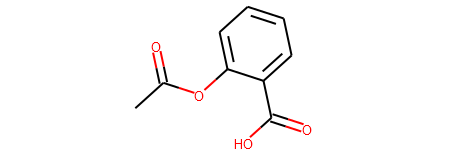

In [6]:
smiles_aspirin = 'CC(=O)Oc1ccccc1C(=O)O'
mol_aspirin = Chem.MolFromSmiles(smiles_aspirin)
mol_aspirin

[conversion.py](https://github.com/marcopodda/fragment-based-dgm/blob/79fd2ad455d5fcc2d462febd3e2125b8fff56a29/molecules/conversion.py#L10)

In [9]:
from rdkit import Chem
from rdkit.Chem import rdmolops


def mol_to_smiles(mol):
    smi = Chem.MolToSmiles(mol, isomericSmiles=True)
    return canonicalize(smi)


def mol_from_smiles(smi):
    smi = canonicalize(smi)
    return Chem.MolFromSmiles(smi)


def canonicalize(smi, clear_stereo=False):
    mol = Chem.MolFromSmiles(smi)
    if clear_stereo:
        Chem.RemoveStereochemistry(mol)
    return Chem.MolToSmiles(mol, isomericSmiles=True)


def mols_to_smiles(mols):
    return [mol_to_smiles(m) for m in mols]


def mols_from_smiles(mols):
    return [mol_from_smiles(m) for m in mols]


def mol_to_graph_data(mol):
    A = rdmolops.GetAdjacencyMatrix(mol)
    node_features, edge_features = {}, {}

    bondidxs = [(b.GetBeginAtomIdx(), b.GetEndAtomIdx())
                for b in mol.GetBonds()]

    for idx in range(A.shape[0]):
        atomic_num = mol.GetAtomWithIdx(idx).GetAtomicNum()
        node_features[idx]["label"] = int(atomic_num)

    for b1, b2 in bondidxs:
        btype = mol.GetBondBetweenAtoms(b1, b2).GetBondTypeAsDouble()
        edge_features[(b1, b2)]["label"] = int(btype)

    return A, node_features, edge_features

In [13]:
import numpy as np
from copy import deepcopy

from rdkit import Chem
from rdkit.Chem import BRICS

dummy = Chem.MolFromSmiles('[*]')


def strip_dummy_atoms(mol):
    hydrogen = mol_from_smiles('[H]')
    mols = Chem.ReplaceSubstructs(mol, dummy, hydrogen, replaceAll=True)
    mol = Chem.RemoveHs(mols[0])
    return mol


def break_on_bond(mol, bond, min_length=3):
    if mol.GetNumAtoms() - bond <= min_length:
        return [mol]

    broken = Chem.FragmentOnBonds(
        mol, bondIndices=[bond],
        dummyLabels=[(0, 0)])

    res = Chem.GetMolFrags(
        broken, asMols=True, sanitizeFrags=False)

    return res


def get_size(frag):
    dummies = count_dummies(frag)
    total_atoms = frag.GetNumAtoms()
    real_atoms = total_atoms - dummies
    return real_atoms


def fragment_iterative(mol, min_length=3):

    bond_data = list(BRICS.FindBRICSBonds(mol))

    try:
        idxs, labs = zip(*bond_data)
    except Exception:
        return []

    bonds = []
    for a1, a2 in idxs:
        bond = mol.GetBondBetweenAtoms(a1, a2)
        bonds.append(bond.GetIdx())

    order = np.argsort(bonds).tolist()
    bonds = [bonds[i] for i in order]

    frags, temp = [], deepcopy(mol)
    for bond in bonds:
        res = break_on_bond(temp, bond)

        if len(res) == 1:
            frags.append(temp)
            break

        head, tail = res
        if get_size(head) < min_length or get_size(tail) < min_length:
            continue

        frags.append(head)
        temp = deepcopy(tail)

    return frags


def fragment_recursive(mol, frags):
    try:
        bonds = list(BRICS.FindBRICSBonds(mol))

        if bonds == []:
            frags.append(mol)
            return frags

        idxs, labs = list(zip(*bonds))

        bond_idxs = []
        for a1, a2 in idxs:
            bond = mol.GetBondBetweenAtoms(a1, a2)
            bond_idxs.append(bond.GetIdx())

        order = np.argsort(bond_idxs).tolist()
        bond_idxs = [bond_idxs[i] for i in order]

        broken = Chem.FragmentOnBonds(mol,
                                      bondIndices=[bond_idxs[0]],
                                      dummyLabels=[(0, 0)])
        head, tail = Chem.GetMolFrags(broken, asMols=True)
        print(mol_to_smiles(head), mol_to_smiles(tail))
        frags.append(head)

        fragment_recursive(tail, frags)
    except Exception:
        pass


def join_molecules(molA, molB):
    marked, neigh = None, None
    for atom in molA.GetAtoms():
        if atom.GetAtomicNum() == 0:
            marked = atom.GetIdx()
            neigh = atom.GetNeighbors()[0]
            break
    neigh = 0 if neigh is None else neigh.GetIdx()

    if marked is not None:
        ed = Chem.EditableMol(molA)
        ed.RemoveAtom(marked)
        molA = ed.GetMol()

    joined = Chem.ReplaceSubstructs(
        molB, dummy, molA,
        replacementConnectionPoint=neigh,
        useChirality=False)[0]

    Chem.Kekulize(joined)
    return joined


def has_dummy_atom(mol):
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() == 0:
            return True
    return False


def count_dummies(mol):
    count = 0
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() == 0:
            count += 1
    return count


def reconstruct(frags, reverse=False):
    if len(frags) == 1:
        return strip_dummy_atoms(frags[0]), frags

    try:
        if count_dummies(frags[0]) != 1:
            return None, None

        if count_dummies(frags[-1]) != 1:
            return None, None

        for frag in frags[1:-1]:
            if count_dummies(frag) != 2:
                return None, None
        
        mol = join_molecules(frags[0], frags[1])
        for i, frag in enumerate(frags[2:]):
            print(i, mol_to_smiles(frag), mol_to_smiles(mol))
            mol = join_molecules(mol, frag)
            print(i, mol_to_smiles(mol))

        # see if there are kekulization/valence errors
        mol_to_smiles(mol)

        return mol, frags
    except Exception:
        return None, None

In [15]:
a = fragment_iterative(mol_aspirin)

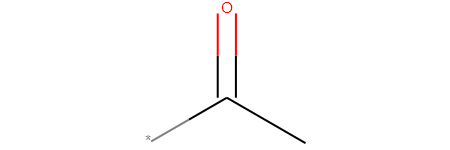

In [16]:
a[0]

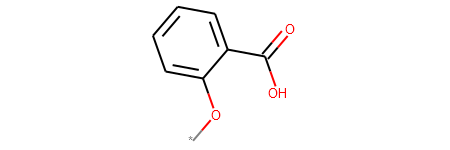

In [17]:
a[1]

In [32]:
fragment_recursive(mol_aspirin, a)

*C(C)=O *Oc1ccccc1C(=O)O
*O* *c1ccccc1C(=O)O
*c1ccccc1* *C(=O)O


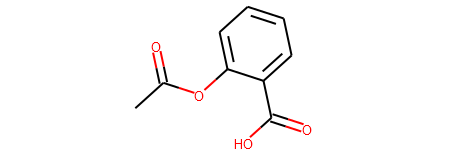

In [34]:
join_molecules(a[1], a[0])

In [44]:
def break_into_fragments(smi):
    mol = Chem.MolFromSmiles(smi)
    
    frags = fragment_iterative(mol)

    if len(frags) == 0:
        return smi, np.nan, 0

    if len(frags) == 1:
        return smi, smi, 1

    rec, frags = reconstruct(frags)
    if rec and mol_to_smiles(rec) == smi:
        fragments = mols_to_smiles(frags)
        return smi, " ".join(fragments), len(frags)

    return smi, np.nan, 0

In [36]:
break_into_fragments(mol_aspirin, smiles_aspirin)

('CC(=O)Oc1ccccc1C(=O)O', '*C(C)=O *Oc1ccccc1C(=O)O', 2)

In [40]:
mol_b = Chem.MolFromSmiles('*Oc1ccccc1C(=O)O')

In [45]:
break_into_fragments('COC(=O)c1c[nH]c2cc(OC(C)C)c(OC(C)C)cc2c1=O')

('COC(=O)c1c[nH]c2cc(OC(C)C)c(OC(C)C)cc2c1=O',
 '*C(=O)OC *c1c[nH]c2cc(OC(C)C)c(OC(C)C)cc2c1=O',
 2)

In [47]:
bond_data = list(BRICS.FindBRICSBonds(mol_aspirin))
bond_data

[((1, 3), ('1', '3')), ((3, 4), ('3', '16')), ((10, 9), ('6', '16'))]

## Model

## Generation